# imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import numpy as np

from tensorflow.keras.layers import Lambda
from tensorflow import slice

print("TensorFlow version is: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version is: {}".format(tf.keras.__version__))

TensorFlow version is: 2.9.1
Eager execution is: True
Keras version is: 2.9.0


# load model

In [4]:
#yolo_tiny_model = load_model('checkpoints/ppe_yolov4-tiny-608-24thAug')
yolo_tiny_model = load_model('checkpoints/yolov4_complete.h5')

In [5]:
yolo_tiny_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 448, 448, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 448, 448, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
yolo_tiny_model.inputs

[<KerasTensor: shape=(None, 448, 448, 3) dtype=float32 (created by layer 'input_1')>]

In [7]:
yolo_tiny_model.outputs

[<KerasTensor: shape=(None, None, 16) dtype=float32 (created by layer 'tf.concat_16')>]

# read labels

In [8]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

In [12]:
#labels = read_labels('data/classes/ppe_classes.names.txt')
labels = read_labels('data/classes/site_od_classes.txt')
labels

['barrier',
 'barrier_angle',
 'barrier_connector',
 'barrier_pad',
 'cone',
 'excavator',
 'excavator_nwl',
 'fire_extinguisher',
 'forklift',
 'ladder',
 'manhole',
 'water_barrier']

# decoder model

In [13]:
num_classes = len(labels)
total_len = 4 + num_classes

In [14]:

inputs = tf.keras.layers.Input(shape=(None, total_len), name='model_input')
slice_x0 = tf.keras.layers.Lambda( lambda x: x[..., 0], name = 'all_x0')(inputs)
slice_y0 = tf.keras.layers.Lambda(lambda x: x[..., 1], name = 'all_y0')(inputs)


slice_width = tf.keras.layers.Lambda(lambda x: x[..., 2], name = 'all_widths')(inputs)


slice_height = tf.keras.layers.Lambda( lambda x: x[..., 3], name = 'all_heights')(inputs)

# slice_height = tf.keras.layers.Subtract()([slice_y1, slice_y0])
# slice_width = tf.keras.layers.Subtract()([slice_x1, slice_x0])

# concatenate_x0_y0 = tf.keras.layers.Concatenate(axis = 0, name='concatenate_x0_y0')([slice_x0, slice_y0, slice_x1, slice_y1])
# transpose_dims = tf.keras.layers.Lambda(lambda x: tf.transpose(x), name ='all_boxes')(concatenate_x0_y0)

concatenate_x0_y0_x1_y1 = tf.keras.layers.Concatenate(axis = 0, name='concatenate_x0_y0_x1_y1')([slice_x0, slice_y0, slice_width, slice_height])
x_y_w_h = tf.keras.layers.Lambda(lambda x: tf.transpose(x), name ='x_y_w_h')(concatenate_x0_y0_x1_y1)
# normalized_x_y_w_h = tf.keras.layers.Lambda(lambda x: x/608.0, name ='normalized_x_y_w_h')(x_y_w_h)

slice_confidences = tf.keras.layers.Lambda(lambda x: x[..., 4:], name = 'slice_confidences')(inputs)
scores = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=0), name = 'all_scores')(slice_confidences)


decoder_model = tf.keras.Model(inputs = [inputs], outputs = [x_y_w_h, scores ], name = 'yolo_decoder')

In [15]:
decoder_model.summary()

Model: "yolo_decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 model_input (InputLayer)       [(None, None, 16)]   0           []                               
                                                                                                  
 all_x0 (Lambda)                (None, None)         0           ['model_input[0][0]']            
                                                                                                  
 all_y0 (Lambda)                (None, None)         0           ['model_input[0][0]']            
                                                                                                  
 all_widths (Lambda)            (None, None)         0           ['model_input[0][0]']            
                                                                                       

# merege yolo and decoder

In [16]:
x = yolo_tiny_model.outputs[0]
x.shape
decoder_model.input.shape

#inputs = tf.keras.layers.Input(shape=(608, 608, 3))
inputs = yolo_tiny_model.input
x = yolo_tiny_model(inputs)
predictions = decoder_model(x)
combined_model = tf.keras.Model(inputs=inputs, outputs=predictions)
combined_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 model (Functional)          (None, None, 16)          70745849  
                                                                 
 yolo_decoder (Functional)   [(None, None),            0         
                              (None, 12)]                        
                                                                 
Total params: 70,745,849
Trainable params: 70,670,841
Non-trainable params: 75,008
_________________________________________________________________


In [17]:
#save combined model
combined_model.save('yolo_decoded.h5')

# check predictions¶

In [18]:
import colorsys
import random

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] ), int(x[1] ), int(x[2] )), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors



In [19]:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, interpolation = 'bilinear', target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

In [20]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def draw_preds_bbs(file_name, preds_pipeline, is_coreml = False):
    print(preds_pipeline[0].shape)
    print(preds_pipeline[1].shape)
    boxes = preds_pipeline[0]
    scores = preds_pipeline[1]
#     boxes = preds_pipeline[2]

    print('start drawing boxes')
    data = pyplot.imread(file_name)
    ax = pyplot.gca()
    colors = generate_colors(labels)
    for i in range(len(boxes)):
        index = i
        box = boxes[index]
        class_id = np.argmax(scores[i])
        score = scores[i][class_id]
        if is_coreml == False :
            x1, y1, height, width = box[0], box[1], box[2], box[3]
        else:
            x1, y1, width, height = box[0], box[1], box[2], box[3]
        
        x1, y1, width, height = box[0], box[1], box[2], box[3]
        
        x1 = x1- width/2.0
        y1 = y1- height/2.0
        
        rect = Rectangle(
            (x1 * image_w, y1 * image_h),
            width * image_w,
            height * image_h,
            fill=False,
            color=colors[class_id]
        )
        ax.add_patch(rect)
        label = "%s (%.3f)" % (labels[class_id], score*100)
        pyplot.text(
            x1* image_w,
            y1* image_h,
            label, 
            color= 'white'
        )
    pyplot.imshow(data)
    pyplot.show()

In [21]:
# Pre-process the image
input_w, input_h = combined_model.input.shape[1], combined_model.input.shape[2]#608, 608
photo_filename = 'sample_test_images/0.jpg'
# photo_filename = 'empty_image.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)
print("input image",image.shape)

image initial size:  1280 720
input image (1, 448, 448, 3)


2022-09-13 12:56:21.353128: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 22s 22s/step
(0, 4)
(0, 12)
start drawing boxes


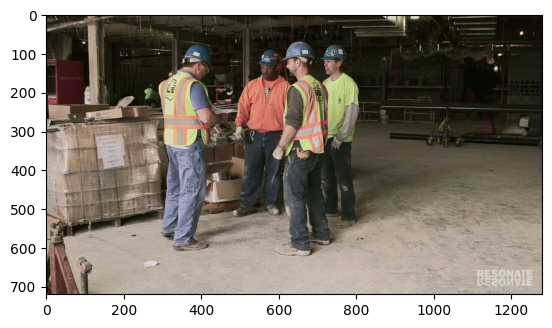

In [22]:
ytinyhat = combined_model.predict(image)
# print(f"ytinyhat shape : {ytinyhat.shape}")
draw_preds_bbs(photo_filename, ytinyhat)